### Preparing Working Env

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
tf.config.run_functions_eagerly(True)

In [2]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tf_explain

In [4]:
from core.networks.resnet_with_conv_finetune import resnetconvfinetune
from core.models.base import WEIGHTS_DIRNAME

### Preparing the Data

In [5]:
ds_train, ds_train_info = tfds.load('RetinaDataset', split='train[:80%]', shuffle_files=True, as_supervised=True,with_info=True)
ds_val, ds_val_info = tfds.load('RetinaDataset', split='train[-20%:]', shuffle_files=True, as_supervised=True,with_info=True)
ds_test, ds_test_info = tfds.load('RetinaDataset', split='test', shuffle_files=True, as_supervised=True,with_info=True)
len(ds_train), len(ds_val), len(ds_test)

C:\Users\mohit\Anaconda3\envs\retina_env\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(66791, 16698, 968)

In [6]:
label_names_list = ds_test_info.features['label'].names

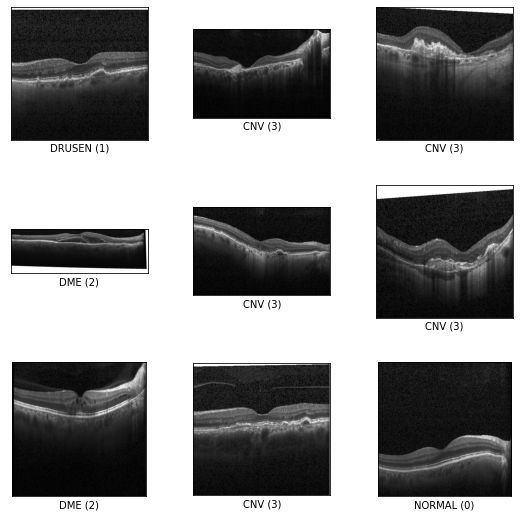

In [7]:
fig = tfds.show_examples(ds_train, ds_train_info)

In [8]:
def preprocess_img(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.
    image = tf.image.resize(image, [224, 224])
    return image, label

NCLASS   = 4
IMG_SIZE = 224

def resize_image(img, lb):
  return tf.image.resize(img, (IMG_SIZE,IMG_SIZE)), tf.one_hot(lb, NCLASS)

In [9]:
ds_train = ds_train.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(32)
ds_val = ds_val.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(32)
# ds_test = ds_test.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(32)

### Preparing the Classification Model with Pre-trained weights

In [10]:
wt_path = str(WEIGHTS_DIRNAME)+"/resnet_with_conv.h5"
wt_path = wt_path.replace('\\','/')

In [11]:
model = resnetconvfinetune(input_shape = (224, 224, 3), output_shape = (4,))
model.load_weights(wt_path)

In [13]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
model.evaluate(ds_test.map(resize_image).batch(32))

31/31 [==============================] - 3s 93ms/step - loss: 0.0358 - accuracy: 0.9928 0s - loss: 0.0381 - ac


[0.035806089639663696, 0.9927685856819153]

### Exploring Saliency Maps

In [17]:
def explain_predictions(image,label,model,layer_name='conv2d_2'):
    label_name = label_names_list[label.numpy()]
    resized_img = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
    resized_img = tf.keras.preprocessing.image.img_to_array(resized_img)
    
    expanded_img = np.expand_dims(resized_img, axis=0)
    prediction = np.argmax(model.predict(expanded_img))
    prediction_acc = np.max(model.predict(expanded_img))
    predicted_label = label_names_list[prediction]
    
    data = ([resized_img.astype('uint8')], None)
    explainer = tf_explain.core.grad_cam.GradCAM()
    grid = explainer.explain(data, model, class_index=label, layer_name=layer_name,image_weight=0.9)
    
    explainer_occ = tf_explain.core.occlusion_sensitivity.OcclusionSensitivity()
    grid_occ = explainer_occ.explain(data, model, class_index=label, patch_size=4)
    
    f, ax = plt.subplots(1,3,figsize = (8,8))
    f.suptitle("True label: " + label_name+", "+"Predicted label: " + predicted_label+", "+"Predicted Accuracy: " + str(prediction_acc), fontsize=15)
    ax[0].set_title("Original Image")
    ax[0].imshow(resized_img.astype('uint8'))
    ax[1].set_title("Grad-CAM")
    ax[1].imshow(grid)
    ax[2].set_title("Occlusion Sensitivity")
    ax[2].imshow(grid_occ)
    plt.tight_layout()
    plt.subplots_adjust(top=1.5)
    plt.show()

In [18]:
def explain_incorrect_predictions(image,label,model,layer_name='conv2d_2'):
    label_name = label_names_list[label.numpy()]
    resized_img = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
    resized_img = tf.keras.preprocessing.image.img_to_array(resized_img)
    
    expanded_img = np.expand_dims(resized_img, axis=0)
    prediction = np.argmax(model.predict(expanded_img))
    prediction_acc = np.max(model.predict(expanded_img))
    predicted_label = label_names_list[prediction]
    
    if label_name==predicted_label:
        return None
    
    data = ([resized_img.astype('uint8')], None)
    explainer = tf_explain.core.grad_cam.GradCAM()
    grid = explainer.explain(data, model, class_index=label, layer_name=layer_name,image_weight=0.9)
    
    explainer_occ = tf_explain.core.occlusion_sensitivity.OcclusionSensitivity()
    grid_occ = explainer_occ.explain(data, model, class_index=label, patch_size=4)
    
    f, ax = plt.subplots(1,3,figsize = (8,8))
    f.suptitle("True label: " + label_name+", "+"Predicted label: " + predicted_label+", "+"Predicted Accuracy: " + str(prediction_acc), fontsize=15)
    ax[0].set_title("Original Image")
    ax[0].imshow(resized_img.astype('uint8'))
    ax[1].set_title("Grad-CAM")
    ax[1].imshow(grid)
    ax[2].set_title("Occlusion Sensitivity")
    ax[2].imshow(grid_occ)
    plt.tight_layout()
    plt.subplots_adjust(top=1.5)
    plt.show()

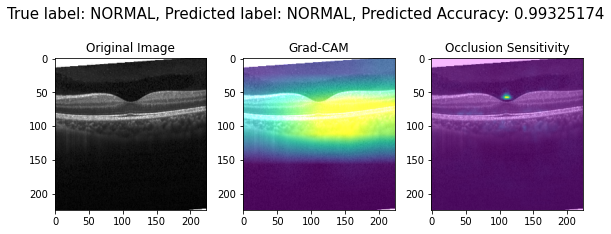

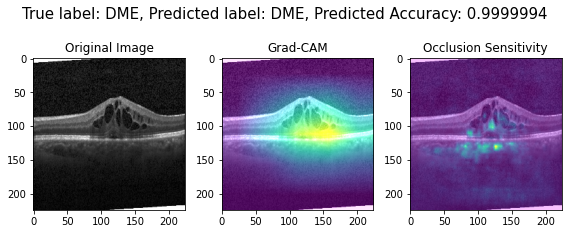

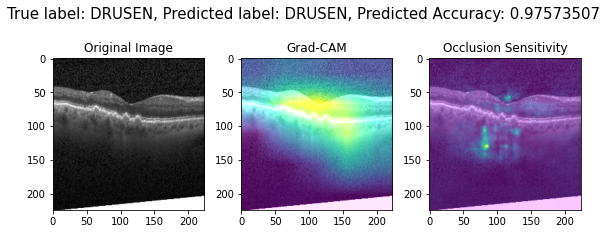

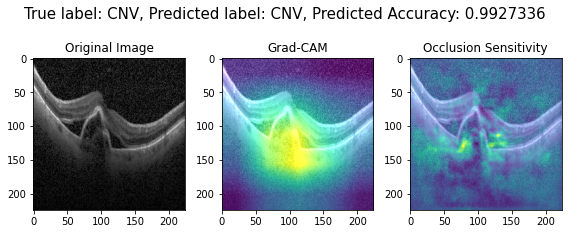

In [23]:
i = 0
for image, label in ds_test:
    explain_predictions(image,label,model=model,layer_name=model.layers[-4].name)
    if i >= 3:
        break
    i+=1

In [24]:
i = 0
tf.config.run_functions_eagerly(True)
for image, label in ds_test:
    explain_incorrect_predictions(image,label,model,layer_name=model.layers[-4].name)
    if i >= 50:
        break
    i+=1

#### END